In [1]:
import torch
import pandas as pd
import numpy as np
import re
import gensim
import collections
import pyarabic.araby as araby
from nltk import ngrams

/home/amr/anaconda3/envs/torch/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Data
### Helping Functions

In [3]:
def normalization(t):
    t = araby.strip_tashkeel(t)
    t = araby.normalize_hamza(t)
    t = araby.normalize_alef(t)
    t = araby.strip_tatweel(t)
    t = araby.normalize_teh(t)
    t = re.sub("ى","ي",t)
    return t

### Data

In [4]:
data= np.load('../translation project/AD_NMT-master/LAV-MSA-2-both.pkl',allow_pickle=True)

In [5]:
data[0] # lav , msa

['لا انا بعرف وحدة راحت ع فرنسا و معا شنتا حطت فيها الفرش',
 'لا اعرف واحدة ذهبت الى فرنسا و لها غرفة و ضعت فيها الافرشة']

In [6]:
# extract only msa text
msa=[]
for i,ex in enumerate(data):
    msa_text = normalization(ex[1])
    data[i][1] = msa_text
    msa.append(msa_text)

In [7]:
msa = ' '.join(msa)

Dictionaries

In [8]:
msa_d=collections.Counter(msa.split())

In [9]:
min_count = 2

In [10]:
idx2msa = np.array([word for word,freq in msa_d.items() if freq > min_count ])

In [11]:
msa2idx = {word:i for i,word in enumerate(idx2msa)}

In [12]:
msa_data = [' '.join([i for i in t[1].split() if (msa2idx.get(i,-1) != -1 and t[1] != '')]) for t in data]

In [13]:
msa_data = [i for i in msa_data if i != '']

In [14]:
lengths = [len(i) for i in msa.split()]

(array([4.8950e+03, 1.9324e+04, 0.0000e+00, 2.4495e+04, 0.0000e+00,
        2.6011e+04, 2.0113e+04, 0.0000e+00, 1.1975e+04, 0.0000e+00,
        6.5210e+03, 1.9170e+03, 0.0000e+00, 4.9600e+02, 0.0000e+00,
        2.2600e+02, 6.2000e+01, 0.0000e+00, 1.1000e+01, 5.0000e+00]),
 array([ 1. ,  1.6,  2.2,  2.8,  3.4,  4. ,  4.6,  5.2,  5.8,  6.4,  7. ,
         7.6,  8.2,  8.8,  9.4, 10. , 10.6, 11.2, 11.8, 12.4, 13. ]),
 <BarContainer object of 20 artists>)

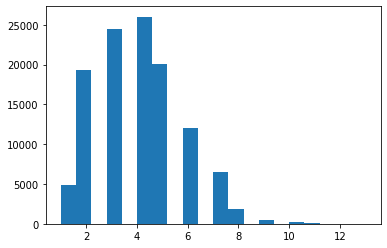

In [15]:
plt.hist(lengths,bins=20)

Load Embeddings

In [16]:
t_model = gensim.models.Word2Vec.load('../resources/models/word vectors/word2vec/wiki/full_grams_cbow_100_wiki/full_grams_cbow_100_wiki.mdl')

In [17]:
i2l = list(set(normalization(araby.LETTERS)))
i2v = {}
for index,letter in enumerate(i2l):
    if letter in t_model.wv.index_to_key :
        i2v[index] = t_model.wv.get_vector(letter)

In [18]:
i2v.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [19]:
i2l.append(' ')#Space
i2l.append('s')#eos
i2l.append('E')#Empty
i2l.append('X')#UNK
i2l.append('P')#pad

In [20]:
l2i = {v:i for i,v in enumerate(i2l)}

In [21]:
len(i2l)

34

## ALL in Model

In [75]:
from torch.utils.data import Dataset,DataLoader

In [76]:
from torch.nn.utils.rnn import pad_sequence 

In [77]:
def noise(txt):
    sz = 2#int(len(txt)*0.2)
    noise_sz = np.random.randint(0,sz if sz>1 else 1,1)
    replace_idx = np.random.choice(len(txt),noise_sz,replace=False)
    letters_idx = np.random.choice(len(i2l)-3,noise_sz,replace=True)
    txt = list(txt)
    for rep,let in zip(replace_idx,letters_idx):
        txt[rep] = i2l[let]
    return ''.join(txt)

In [97]:
class arrDs(Dataset):
    def __init__(self,txt_list,l2i):
        self.data = txt_list
        self.l2i = l2i
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        X = noise(self.data[idx])
        Y = self.data[idx]
        
        X = torch.tensor([self.l2i.get(i,31) for i in X])
        Y = torch.tensor([self.l2i.get(i,31) for i in Y])
        #numerilize
        return (X,Y)

In [131]:
trn_data, val_data = msa_grams[:int(0.8*len(msa_grams))],msa_grams[int(0.8*len(msa_grams)):]

In [132]:
trn_ds,val_ds = arrDs(trn_data,l2i),arrDs(val_data,l2i)

In [133]:
def collate_fn(data):
    label  = [i for _,i in data]
    label = pad_sequence(label,batch_first=True,padding_value=l2i['P'])
    data = [i for i,_ in data]
    data = pad_sequence(data,batch_first=True,padding_value=l2i['P'])
    return data,label

In [134]:
trn_dl = DataLoader(trn_ds,batch_size=512,collate_fn=collate_fn,drop_last=False,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=512,collate_fn=collate_fn,drop_last=False)

Model

In [135]:
import torch, torch.nn as nn

In [136]:
class autocorrect(nn.Module):
    def __init__(self,num_emb,vs,hs,bidirectional=True):
        super().__init__()
        self.emb = nn.Embedding(num_emb,vs)
        self.gru = nn.GRU(vs,hs,num_layers=3,bidirectional=bidirectional,batch_first=True,dropout=0.2)
        self.lin = nn.Sequential(nn.Linear(2*hs if bidirectional == True else hs,hs),
                                 nn.ReLU(),
                                 nn.Linear(hs,num_emb))
    def forward(self,x):
        bs,seq_len=x.shape
        x = torch.relu(self.emb(x))
        x,_ = self.gru(x)
        x = nn.functional.relu(x)
        x = self.lin(x)
        return torch.log_softmax(x,dim=-1).view(bs*seq_len,-1)

In [137]:
num_emb = len(i2l)

In [138]:
model = autocorrect(num_emb,100,512).cuda()

In [139]:
#Load available vectors
model.emb.weight.requires_grad_(False)
for i in i2v.keys():
    model.emb.weight[i] = nn.Parameter(torch.from_numpy(i2v[i].copy())).requires_grad_(False)
model.emb.weight.requires_grad_(True);

In [140]:
opt = torch.optim.Adam(model.parameters(),lr=1e-3)

In [141]:
loss = nn.CrossEntropyLoss(ignore_index=l2i['P'])

In [142]:
def train(epoch,model,trn_dl,val_dl,loss_fnc):
    model.train()
    for i in range(epoch):
        model.train()
        for batch in tqdm(trn_dl,desc='train'):
            opt.zero_grad()
            ip,label = batch
            op = model(ip.cuda())
            trn_l = loss_fnc(op,label.view(-1).cuda())
            trn_l.backward()
            opt.step()
        
        with torch.no_grad():
            model.eval()
            for batch in tqdm(val_dl,desc='validation'):
                ip,label = batch
                op = model(ip.cuda())
                val_loss = loss_fnc(op,label.view(-1).cuda())
        print('train_loss ->',trn_l.item() , 'val_loss ->',val_loss.item())

In [143]:
train(4,model,trn_dl,val_dl,loss)

validation: 100%|██████████| 193/193 [00:11<00:00, 16.63it/s]


train_loss -> 0.15521708130836487 val_loss -> 0.17286837100982666


validation: 100%|██████████| 193/193 [00:11<00:00, 16.51it/s]


train_loss -> 0.10659952461719513 val_loss -> 0.13384029269218445


validation: 100%|██████████| 193/193 [00:11<00:00, 16.70it/s]


train_loss -> 0.13054075837135315 val_loss -> 0.12543432414531708


validation: 100%|██████████| 193/193 [00:11<00:00, 16.46it/s]

train_loss -> 0.13228930532932281 val_loss -> 0.10668586194515228


# Seq to Seq

In [22]:
from torch.utils.data import Dataset,DataLoader
import tqdm
import random

In [23]:
def get_ngrams(txt,ws=15):
    ignore = ws-2
    txt = list(txt)
    grams = ngrams(txt,ws ,pad_left=True,pad_right=True,left_pad_symbol='Q',right_pad_symbol='W')
    return list(grams)[ignore:-ignore]

In [24]:
msa_grams=[]
for txt in msa_data:
    ng = get_ngrams(txt)
    if ng:
        msa_grams.extend(ng)

In [25]:
def noise(txt):
    sz = int(len(txt)*0.2)
    noise_sz = np.random.randint(0,sz if sz>1 else 1,1)
    replace_idx = np.random.choice(len(txt),noise_sz,replace=False)
    letters_idx = np.random.choice(len(i2l)-3,noise_sz,replace=True)
    txt = list(txt)
    for rep,let in zip(replace_idx,letters_idx):
        txt[rep] = i2l[let]
    return ''.join(txt)

In [26]:
class arrDs(Dataset):
    def __init__(self,txt_list,l2i):
        self.data = txt_list
        self.l2i = l2i
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        #X = noise(self.data[idx])
        X = noise(self.data[idx])
        Y = self.data[idx]
        
        X = torch.tensor([self.l2i.get(i,31) for i in X])
        Y = torch.tensor([self.l2i.get(i,31) for i in Y])
        #numerilize
        return torch.stack([X,Y])

In [27]:
trn_data, val_data = msa_grams[:int(0.8*len(msa_grams))],msa_grams[int(0.8*len(msa_grams)):]

In [28]:
trn_ds,val_ds = arrDs(trn_data,l2i),arrDs(val_data,l2i)

In [29]:
trn_dl = DataLoader(trn_ds,batch_size=256,drop_last=False)
val_dl = DataLoader(val_ds,batch_size=256,drop_last=False)

In [34]:
?nn.CrossEntropyLoss

Model

In [30]:
import torch, torch.nn as nn

In [136]:
class autocorrect(nn.Module):
    def __init__(self,num_emb,vs,hs,bidirectional=True):
        super().__init__()
        self.hs = hs
        self.emb = nn.Embedding(num_emb,vs)
        self.enc_gru = nn.GRU(vs,hs,num_layers=1,bidirectional=False,batch_first=True)
        self.dec_gru = nn.GRU(hs,hs,num_layers=1,bidirectional=False,batch_first=True)
        self.lin = nn.Sequential(nn.Linear(hs,hs),
                                 nn.ReLU(),
                                 nn.Linear(hs,num_emb))
    def forward(self,x):
        bs,seq_len=x.shape
        x = self.emb(x)
        #print('emb',x.shape)
        x = self.enc_gru(x)
        #print('enc',x[0].shape)
        op=[]
        sos = torch.zeros(bs,1,self.hs).cuda()
        h = x[1]
        for i in range(15):
            sos,h = model.dec_gru(sos,h)
            op.append(h.detach())
        #    print('h',h.shape)
        x = torch.stack(op,dim=1).squeeze().permute(1,0,2)
        
        x = self.lin(x)
        return torch.log_softmax(x,dim=-1).permute(0,2,1).contiguous().view(bs*seq_len,-1)

In [144]:
num_emb = len(i2l)

In [178]:
model = autocorrect(num_emb,100,512).cuda()

In [179]:
#Load available vectors
model.emb.weight.requires_grad_(False)
for i in i2v.keys():
    model.emb.weight[i] = nn.Parameter(torch.from_numpy(i2v[i].copy())).requires_grad_(False)
model.emb.weight.requires_grad_(True);

In [180]:
opt = torch.optim.Adam(model.parameters(),lr=1e-3)

In [181]:
loss = nn.CrossEntropyLoss(ignore_index=32)

In [182]:
def train(epoch,model,trn_dl,val_dl,loss_fnc):
    model.train()
    for i in range(epoch):
        model.train()
        for batch in tqdm.tqdm(trn_dl,'train'):
            opt.zero_grad()
            ip,label = batch[:,0,:],batch[:,1,:]
            op = model(ip.cuda())
            trn_l = loss_fnc(op,label.contiguous().view(-1).cuda())
            trn_l.backward()
            opt.step()
        with torch.no_grad():
            model.eval()
            for batch in tqdm.tqdm(val_dl,'validation'):
                ip,label = batch[:,0,:],batch[:,1,:]
                op = model(ip.cuda())
                val_loss = loss_fnc(op,label.contiguous().view(-1).cuda())
        print('train_loss ->',trn_l.item() , 'val_loss ->',val_loss.item())

In [183]:
train(10,model,trn_dl,val_dl,loss)

validation: 100%|██████████| 249/249 [00:06<00:00, 36.99it/s]


train_loss -> 2.8029258251190186 val_loss -> 2.6647675037384033


validation: 100%|██████████| 249/249 [00:06<00:00, 37.26it/s]


train_loss -> 2.6925783157348633 val_loss -> 2.52119779586792


validation: 100%|██████████| 249/249 [00:06<00:00, 36.86it/s]


train_loss -> 2.595806837081909 val_loss -> 2.482649564743042


validation: 100%|██████████| 249/249 [00:06<00:00, 37.68it/s]


train_loss -> 2.5575501918792725 val_loss -> 2.472534418106079


validation: 100%|██████████| 249/249 [00:06<00:00, 37.02it/s]


train_loss -> 2.5475142002105713 val_loss -> 2.416454792022705


validation: 100%|██████████| 249/249 [00:06<00:00, 37.33it/s]


train_loss -> 2.514843463897705 val_loss -> 2.3395650386810303


validation: 100%|██████████| 249/249 [00:06<00:00, 37.17it/s]


train_loss -> 2.460703134536743 val_loss -> 2.3499512672424316


validation: 100%|██████████| 249/249 [00:06<00:00, 37.33it/s]


train_loss -> 2.45233154296875 val_loss -> 2.3488595485687256


validation: 100%|██████████| 249/249 [00:06<00:00, 36.71it/s]


train_loss -> 2.422328472137451 val_loss -> 2.3380918502807617


validation: 100%|██████████| 249/249 [00:06<00:00, 37.61it/s]

train_loss -> 2.4123878479003906 val_loss -> 2.324697494506836


In [184]:
a = iter(val_dl)

In [185]:
d = next(a)

In [186]:
d.shape

torch.Size([256, 2, 15])

In [187]:
d[0]

tensor([[13, 18,  2,  4,  5, 29, 21,  1, 16, 29,  4,  3, 21, 29,  1],
        [13, 29,  2,  4,  5, 29, 21,  1, 16, 29,  4,  3, 20, 29,  1]])

In [188]:
model(d[0].cuda()).argmax(-1)

tensor([29,  4, 29, 29, 29, 29, 29,  4, 29, 29, 21, 21,  4, 29,  1, 29,  4, 29,
        29, 29, 29, 29,  4, 29, 29, 20,  4,  4, 29,  1], device='cuda:0')

In [202]:
class autocorrect(nn.Module):
    def __init__(self,num_emb,vs,hs,bidirectional=True):
        super().__init__()
        self.hs = hs
        self.emb = nn.Embedding(num_emb,vs)
        self.lin = nn.Linear(vs,num_emb)
    def forward(self,x):
        bs,seq_len=x.shape
        x = self.emb(x)
        #print('emb',x.shape)
        x = self.lin(x)
        x = torch.softmax(x,dim=-1)
        
        return x.view(bs*seq_len,-1)